In [1]:

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.optimize import curve_fit



### Enhanced OFC Model Implementation



In [2]:

class EnhancedOFC:
    def __init__(self, threshold, alpha, lattice_size, boundary='open', rng_seed=None):
        """Initialize OFC model with boundary condition options and random lattice stress values."""
        self.rng = np.random.default_rng(rng_seed)
        self.threshold = threshold
        self.alpha = alpha
        self.lattice_size = lattice_size
        self.boundary = boundary
        self.lattice = self.threshold * self.rng.random((lattice_size, lattice_size))
        self.event_history = []

    def get_neighbors(self, site):
        """Retrieve neighbors for a given site under specified boundary conditions."""
        row, col = site
        neighbors = []
        if self.boundary == 'open':
            # Open boundary conditions (no wrapping)
            if row < self.lattice_size - 1: neighbors.append((row + 1, col))
            if col < self.lattice_size - 1: neighbors.append((row, col + 1))
            if row > 0: neighbors.append((row - 1, col))
            if col > 0: neighbors.append((row, col - 1))
        elif self.boundary == 'periodic':
            # Periodic boundary conditions (wrapping)
            neighbors = [
                ((row + 1) % self.lattice_size, col),
                ((row - 1) % self.lattice_size, col),
                (row, (col + 1) % self.lattice_size),
                (row, (col - 1) % self.lattice_size)
            ]
        return neighbors

    def drive_plate(self):
        """Increase stress on the lattice until failure and propagate avalanche."""
        active_sites = deque()
        max_value = np.max(self.lattice)
        active_sites.append(np.unravel_index(np.argmax(self.lattice), self.lattice.shape))
        self.lattice += (self.threshold - max_value)
        event_size = 0
        while active_sites:
            current_site = active_sites.popleft()
            if self.lattice[current_site] >= self.threshold:
                neighbors = self.get_neighbors(current_site)
                for neighbor in neighbors:
                    self.lattice[neighbor] += self.alpha * self.lattice[current_site]
                    active_sites.append(neighbor)
                self.lattice[current_site] = 0
                event_size += 1
        return event_size

    def simulate(self, num_events, transient=0):
        """Run model for a given number of events, optionally with transient steps."""
        for _ in range(transient):
            _ = self.drive_plate()
        for _ in range(num_events):
            event_size = self.drive_plate()
            self.event_history.append(event_size)
        return self.event_history



### Running the Enhanced Model
Set parameters, run the model, and then fit a power law to the event size distribution.


In [3]:

# Model parameters
threshold = 1.0
alpha = 0.2  # Non-conservative model; set to 0.25 for no dissipation.
lattice_size = 50  # Using smaller lattice for quicker demonstration
transient_steps = 1000
num_events = 5000

# Initialize and run the model with periodic boundary conditions
model = EnhancedOFC(threshold=threshold, alpha=alpha, lattice_size=lattice_size, boundary='periodic', rng_seed=1)
event_history = model.simulate(num_events=num_events, transient=transient_steps)

print("Simulation complete with periodic boundary conditions.")


Simulation complete with periodic boundary conditions.



### Plotting the Event Size Distribution
Plot the distribution of avalanche sizes to visualize potential power-law behavior.


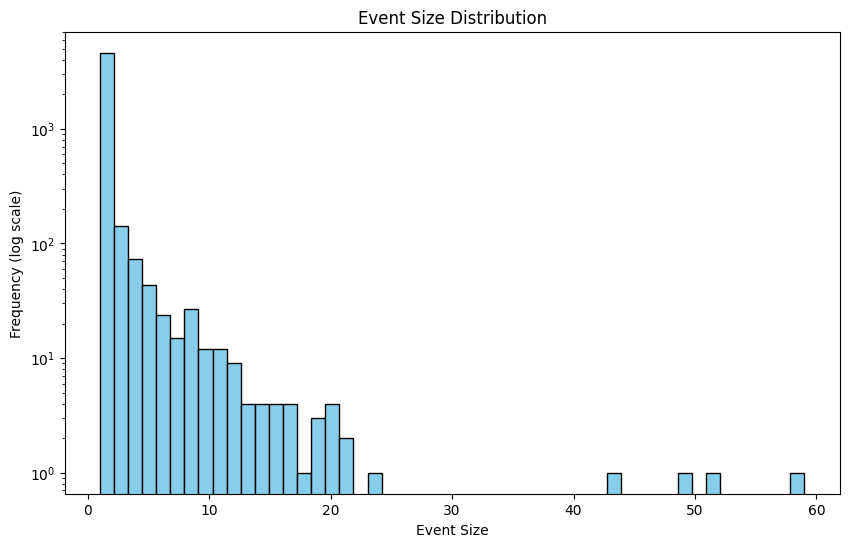

In [4]:

plt.figure(figsize=(10, 6))
plt.hist(event_history, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title('Event Size Distribution')
plt.xlabel('Event Size')
plt.ylabel('Frequency (log scale)')
plt.show()



### Fitting a Power-Law to the Event Size Distribution
Now fit the event size distribution to a power-law function of the form:
\[ f(x) = A \cdot x^{-b} \]
to extract the exponent \( b \).


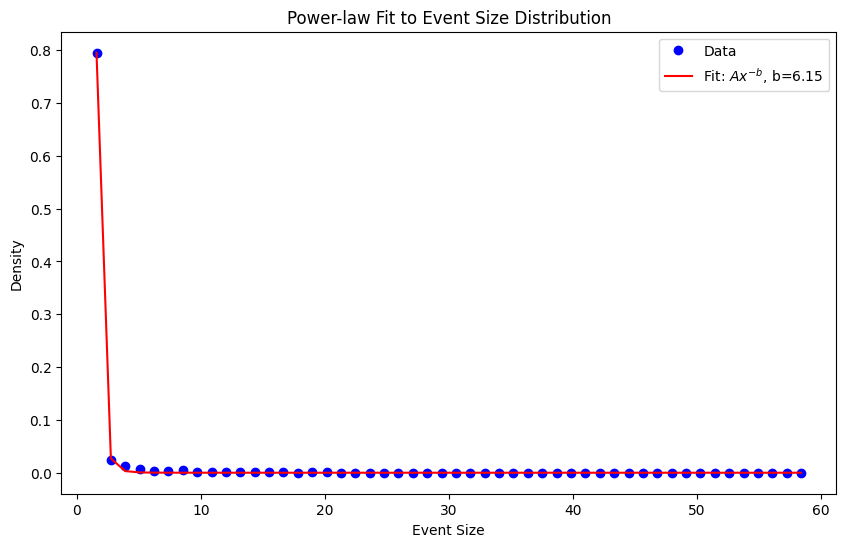

Fitted power-law exponent: b = 6.15


In [5]:

# Define power-law fitting function
def power_law(x, A, b):
    return A * x ** (-b)

# Filter event history to ignore zero-sized events
filtered_event_history = np.array([size for size in event_history if size > 0])
hist, bin_edges = np.histogram(filtered_event_history, bins=50, density=True)

# Use midpoint of bins for fitting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit power-law to histogram data
popt, pcov = curve_fit(power_law, bin_centers, hist, p0=[1, 1.5])

# Plot fitted power-law
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist, 'bo', label="Data")
plt.plot(bin_centers, power_law(bin_centers, *popt), 'r-', label=f"Fit: $A x^{{-b}}$, b={popt[1]:.2f}")
plt.title("Power-law Fit to Event Size Distribution")
plt.xlabel("Event Size")
plt.ylabel("Density")
plt.legend()
plt.show()

# Display fitted exponent value
print(f"Fitted power-law exponent: b = {popt[1]:.2f}")
